In [20]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from observational_fear import load
from neurobox.wide_transforms import resample
from binit.align import align_around
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [21]:
DATA_DIR = Path(r"F:\OFL\one-p experiment\data")
FIG_DIR = Path(r"C:\Users\roryl\repos\observational-fear\figs")

In [42]:
def get_mouse_cells(df_cells, mouse):
    return df_cells.loc[lambda x: x.mouse == mouse].new_id.unique()


def get_mouse_data(mouse, df_traces, df_freeze):
    cells = get_mouse_cells(df_cells, mouse)
    dft = df_traces[[c for c in df_traces.columns if c in cells or c == "time"]].copy()
    dff = df_freeze.loc[lambda x: x.mouse_name == mouse].copy()
    return dft, dff


def resample_two(df_traces, df_freeze, interval, freeze_col):
    df_traces = resample(df_traces.set_index("time"), interval).dropna()
    df_freeze.index = df_freeze["time"].round(2)
    df_freeze = resample(df_freeze[[freeze_col]], interval).round()
    df_freeze = df_freeze.reindex(df_traces.index, method="bfill")
    df_freeze = df_freeze.rename(columns={freeze_col: "freeze_status"})
    return df_traces, df_freeze


def fit_model(dft, dff, pipe, shuffle=False):
    X_train, X_test, y_train, y_test = train_test_split(dft, dff, shuffle=shuffle)
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)
    f1 = metrics.f1_score(y_test, y_hat)
    return f1, pipe


def get_hat(dft, dff, fitted_model, time_before=5, time_after=5):
    pred = fitted_model.predict(dft).flatten()
    pred_proba = fitted_model.predict_proba(dft)[:, 1].flatten()
    true_state = dff.values.flatten()
    time = dff.index.values.flatten()
    hat = pd.DataFrame(
        {"time": time, "pred": pred, "pred_proba": pred_proba, "true_state": true_state}
    ).sort_values("time")
    freeze_starts = dff.loc[
        lambda x: x["freeze_status"].diff() == 1
    ].index.values  # freeze_onsets
    freeze_stops = dff.loc[
        lambda x: x["freeze_status"].diff() == -1
    ].index.values  # freeze_offsets
    hat["onset_aligned"] = align_around(
        hat["time"].values, freeze_starts, t_before=time_before, max_latency=time_after
    )
    hat["offset_aligned"] = align_around(
        hat["time"].values, freeze_stops, t_before=time_before, max_latency=time_after
    )
    return hat


def run_decoder(
    dft,
    dff,
    pipe,
    resample_interval="100ms",
    time_before=5,
    time_after=5,
    freeze_col="was_freezing_obs",
    shuffle=False
):
    dft, dff = resample_two(dft, dff, interval=resample_interval, freeze_col=freeze_col)
    f1, pipe_fitted = fit_model(dft, dff, pipe, shuffle=shuffle)
    hat = get_hat(
        dft,
        dff,
        fitted_model=pipe_fitted,
        time_before=time_before,
        time_after=time_after,
    )
    return f1, hat


In [93]:
import warnings
warnings.filterwarnings("ignore")

session = "day2"

df_freeze = load.load_freeze(DATA_DIR, session=session)
df_cells = load.load_cells(DATA_DIR)
df_cells["new_id"] = df_cells["new_id"].astype("str") 
df_traces = load.load_traces(DATA_DIR, session=session)

pipe = make_pipeline(
    RandomForestClassifier(n_estimators=220, max_depth=4),
)

mice = df_cells.mouse.unique()
f1s = []
hats = []
for mouse in mice:
    print(mouse)
    dft, dff = get_mouse_data(mouse, df_traces, df_freeze)
    f1, hat = run_decoder(dft, dff, clone(pipe), resample_interval="200ms", shuffle=True, time_before=5, time_after=5)
    hat["mouse"] = mouse
    hats.append(hat)
    f1s.append(f1)

f1s = pd.DataFrame({"mouse": mice, "f1": f1s})
df_hat = pd.concat(hats).reset_index(drop=True)

B17274
B17276
B43396
PL-OFL-2
PL-OFL-4
PL-OFL-5
PL-OFL-6
PL-OFL-7


<AxesSubplot:xlabel='onset_aligned', ylabel='value'>

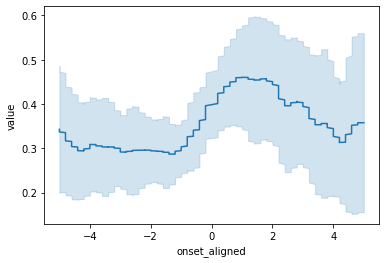

In [94]:
from scipy.ndimage import gaussian_filter1d

dfp = (
    df_hat
    .pivot_table(index="onset_aligned", columns="mouse", values="pred_proba", aggfunc=np.median)
    .bfill()
    .apply(gaussian_filter1d, sigma=10)
    .reset_index()
    .melt(id_vars="onset_aligned")
)


sns.lineplot(data=dfp, x="onset_aligned", y="value", ci="sd")
# plt.axhline(0.5)

<AxesSubplot:xlabel='offset_aligned', ylabel='value'>

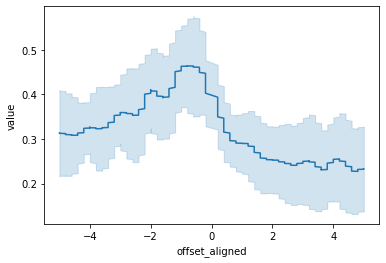

In [95]:
import matplotlib.pyplot as plt
import numpy as np



dfp = (
    df_hat
    .pivot_table(index="offset_aligned", columns="mouse", values="pred_proba", aggfunc=np.mean)
    .bfill()
    .apply(gaussian_filter1d, sigma=10)
    .reset_index()
    .melt(id_vars="offset_aligned")
)


sns.lineplot(data=dfp, x="offset_aligned", y="value", ci="sd")
# plt.axhline(0.5)

(0.0, 1.0)

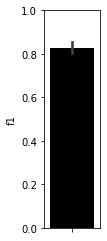

In [104]:
plt.figure(figsize=(1,4))
sns.barplot(data=f1s, y="f1", color="black")
plt.ylim(0, 1)